# 2. Preprocessing & Feature Engineering

This notebook covers:
1. Audio preprocessing pipeline
2. Log-mel spectrogram extraction
3. Feature normalization
4. SpecAugment demonstration
5. Feature extraction for Random Forest
6. PyTorch Dataset creation

In [ ]:
# Imports
import sys
sys.path.insert(0, '..')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from src import config
from src.data_utils import load_manifest
from src.audio_utils import (
    load_audio,
    crop_or_pad,
    extract_log_mel,
    normalize_mel,
    SpecAugment,
    preprocess_audio,
    extract_rf_features
)
from src.dataset import EDMDataset, RFDataset, create_dataloaders

plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
# Load manifest
manifest = load_manifest()
print(f"Loaded {len(manifest)} samples")
# Filter to only tracks that ACTUALLY EXIST
from pathlib import Path
manifest_valid = manifest[manifest['filepath'].apply(lambda x: Path(x).exists())]
print(f"Valid (existing) files: {len(manifest_valid)}")
# Get a sample track for demonstration
sample_row = manifest_valid.sample(1, random_state=42).iloc[0]
sample_path = sample_row['filepath']
print(f"\nSample track: {sample_row['track_id']} ({sample_row['label']})")

Loaded 2517 samples
Valid (existing) files: 2517

Sample track: track_0385372 (trance)


## 1. Audio Loading

Waveform shape: torch.Size([1, 6178960])
Sample rate: 22050 Hz
Duration: 280.22 s


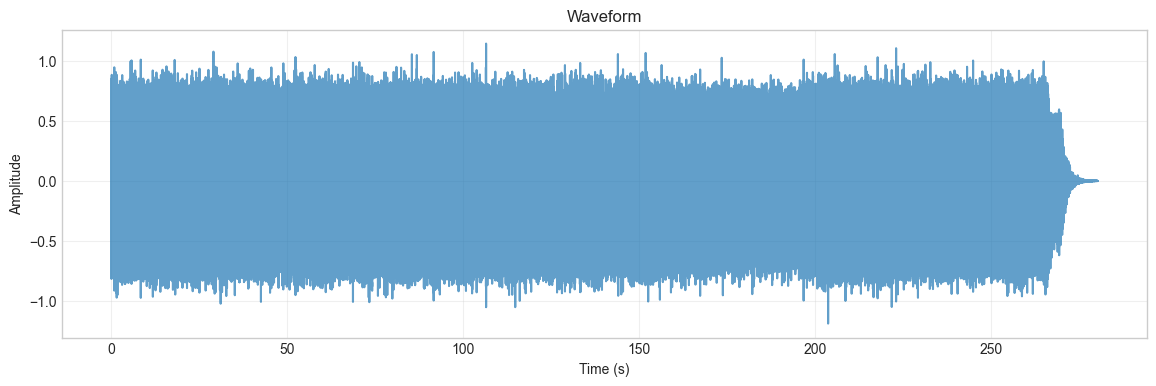

In [ ]:
# Load audio
waveform, sr = load_audio(sample_path)
print(f"Waveform shape: {waveform.shape}")
print(f"Sample rate: {sr} Hz")
print(f"Duration: {waveform.shape[-1] / sr:.2f} s")

# Plot waveform
plt.figure(figsize=(14, 4))
time_axis = np.arange(waveform.shape[-1]) / sr
plt.plot(time_axis, waveform.squeeze().numpy(), alpha=0.7)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.show()

## 2. Cropping and Padding

Target length: 220500 samples (10s)
Current length: 6178960 samples

Center cropped shape: torch.Size([1, 220500])
Random cropped shape: torch.Size([1, 220500])


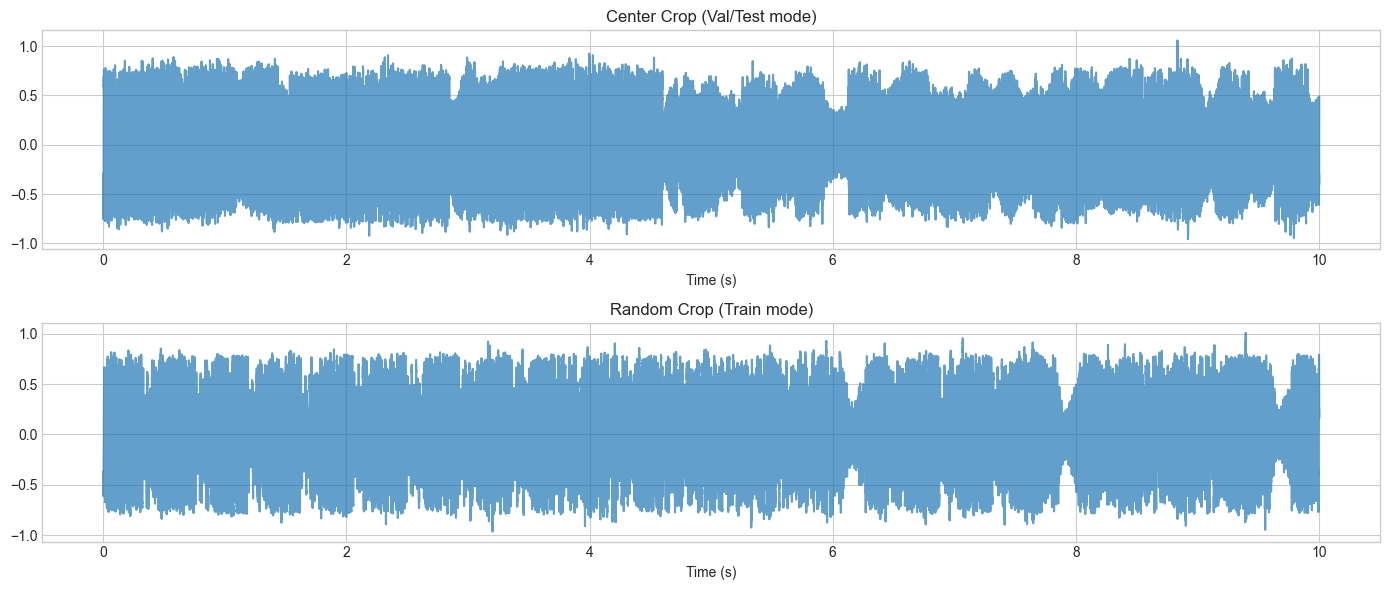

In [ ]:
# Target length
target_samples = config.CLIP_SAMPLES
print(f"Target length: {target_samples} samples ({config.CLIP_DURATION_SEC}s)")
print(f"Current length: {waveform.shape[-1]} samples")

# Center crop
cropped_center = crop_or_pad(waveform, target_samples, mode='center')
print(f"\nCenter cropped shape: {cropped_center.shape}")

# Random crop (train mode)
cropped_random = crop_or_pad(waveform, target_samples, mode='random')
print(f"Random cropped shape: {cropped_random.shape}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

time_axis = np.arange(target_samples) / sr
axes[0].plot(time_axis, cropped_center.squeeze().numpy(), alpha=0.7)
axes[0].set_title('Center Crop (Val/Test mode)')
axes[0].set_xlabel('Time (s)')

axes[1].plot(time_axis, cropped_random.squeeze().numpy(), alpha=0.7)
axes[1].set_title('Random Crop (Train mode)')
axes[1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

## 3. Log-Mel Spectrogram Extraction

In [ ]:
# Extract log-mel spectrogram
mel = extract_log_mel(
    cropped_center,
    sample_rate=sr,
    n_fft=config.N_FFT,
    hop_length=config.HOP_LENGTH,
    n_mels=config.N_MELS
)

print(f"Log-mel spectrogram shape: {mel.shape}")
print(f"  Channels: {mel.shape[0]}")
print(f"  Mel bins: {mel.shape[1]}")
print(f"  Time frames: {mel.shape[2]}")
print(f"\nValue range: [{mel.min():.2f}, {mel.max():.2f}]")

Log-mel spectrogram shape: torch.Size([1, 128, 862])
  Channels: 1
  Mel bins: 128
  Time frames: 862

Value range: [-35.87, 44.13]


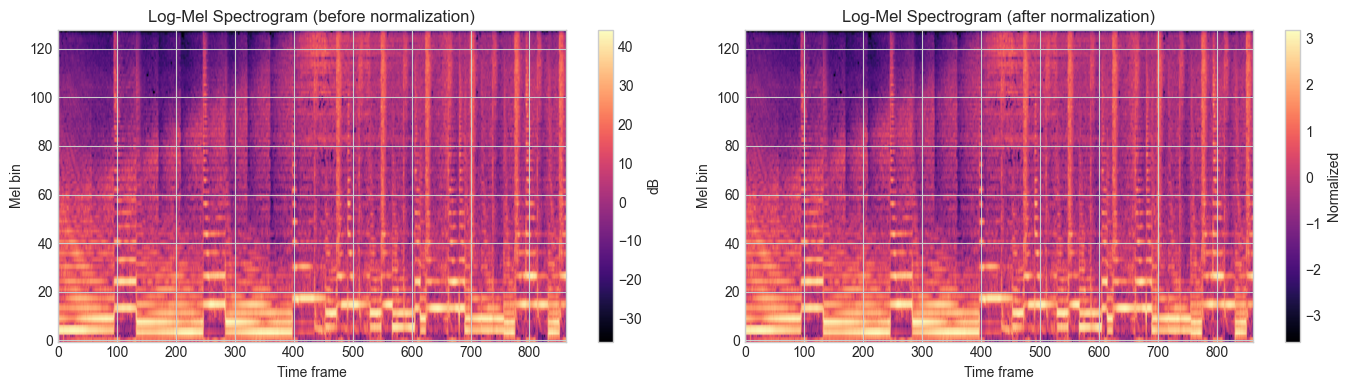


After normalization:
  Mean: 0.0000
  Std: 1.0000


In [ ]:
# Visualize spectrogram
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Before normalization
im1 = axes[0].imshow(mel.squeeze().numpy(), aspect='auto', origin='lower', cmap='magma')
axes[0].set_title('Log-Mel Spectrogram (before normalization)')
axes[0].set_xlabel('Time frame')
axes[0].set_ylabel('Mel bin')
plt.colorbar(im1, ax=axes[0], label='dB')

# After normalization
mel_norm = normalize_mel(mel)
im2 = axes[1].imshow(mel_norm.squeeze().numpy(), aspect='auto', origin='lower', cmap='magma')
axes[1].set_title('Log-Mel Spectrogram (after normalization)')
axes[1].set_xlabel('Time frame')
axes[1].set_ylabel('Mel bin')
plt.colorbar(im2, ax=axes[1], label='Normalized')

plt.tight_layout()
plt.savefig(config.RESULTS_DIR / 'preprocessing_mel.png', dpi=150)
plt.show()

print(f"\nAfter normalization:")
print(f"  Mean: {mel_norm.mean():.4f}")
print(f"  Std: {mel_norm.std():.4f}")

## 4. SpecAugment

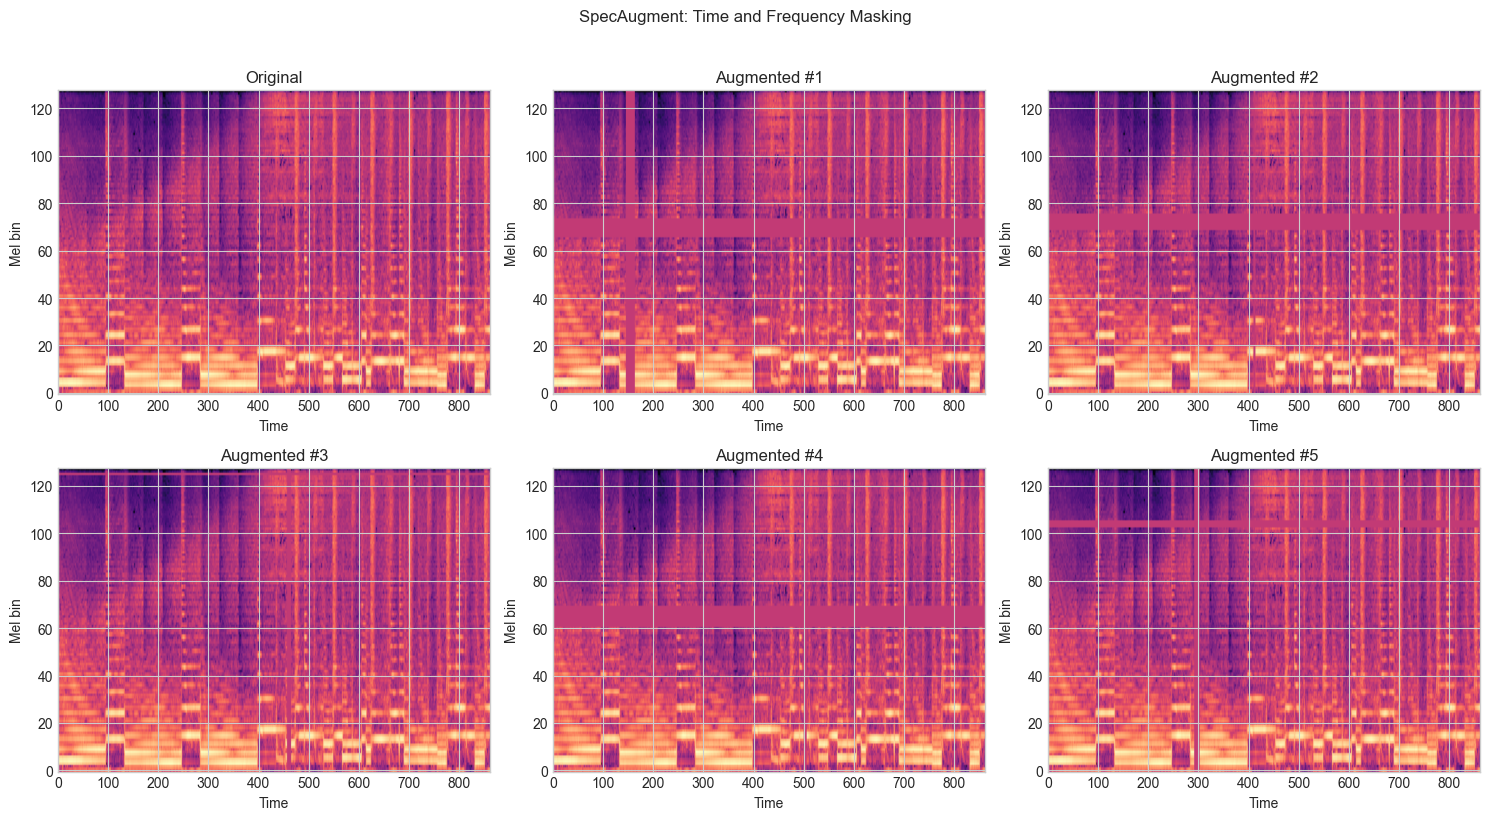

In [ ]:
# SpecAugment demonstration
augmenter = SpecAugment(
    freq_mask_param=config.FREQ_MASK_PARAM,
    time_mask_param=config.TIME_MASK_PARAM
)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Original
axes[0, 0].imshow(mel_norm.squeeze().numpy(), aspect='auto', origin='lower', cmap='magma')
axes[0, 0].set_title('Original')

# Apply augmentation multiple times
for i in range(5):
    ax = axes[(i+1)//3, (i+1)%3]
    augmented = augmenter(mel_norm.clone())
    ax.imshow(augmented.squeeze().numpy(), aspect='auto', origin='lower', cmap='magma')
    ax.set_title(f'Augmented #{i+1}')

for ax in axes.flat:
    ax.set_xlabel('Time')
    ax.set_ylabel('Mel bin')

plt.suptitle('SpecAugment: Time and Frequency Masking', y=1.02)
plt.tight_layout()
plt.savefig(config.RESULTS_DIR / 'preprocessing_specaugment.png', dpi=150)
plt.show()

## 5. Full Preprocessing Pipeline

In [ ]:
# Full pipeline: load -> crop -> mel -> normalize
mel_processed = preprocess_audio(sample_path, mode='center', augment=False)
print(f"Final preprocessed shape: {mel_processed.shape}")

# Verify consistent shape
expected_time_frames = config.CLIP_SAMPLES // config.HOP_LENGTH + 1
print(f"Expected time frames: {expected_time_frames}")
print(f"Actual time frames: {mel_processed.shape[-1]}")

Final preprocessed shape: torch.Size([1, 128, 862])
Expected time frames: 862
Actual time frames: 862


## 6. Feature Extraction for Random Forest

Extract statistical features from spectrograms for classical ML.

In [ ]:
# Extract RF features
rf_features = extract_rf_features(mel_processed)
print(f"RF feature vector shape: {rf_features.shape}")
print(f"\nFeature statistics:")
print(f"  Min: {rf_features.min():.4f}")
print(f"  Max: {rf_features.max():.4f}")
print(f"  Mean: {rf_features.mean():.4f}")
print(f"  Std: {rf_features.std():.4f}")

RF feature vector shape: (1536,)

Feature statistics:
  Min: -4.4806
  Max: 16.7529
  Mean: 0.3387
  Std: 1.6109


In [ ]:
# Feature breakdown
n_mel_bins = config.N_MELS
features_per_bin = 6  # mean, std, min, max, skew, kurtosis

print(f"Feature breakdown:")
print(f"  Mel bins: {n_mel_bins}")
print(f"  Statistics per bin: {features_per_bin}")
print(f"  Mel features: {n_mel_bins * features_per_bin}")
print(f"  Delta features: {n_mel_bins * features_per_bin}")
print(f"  Total: {n_mel_bins * features_per_bin * 2}")

Feature breakdown:
  Mel bins: 128
  Statistics per bin: 6
  Mel features: 768
  Delta features: 768
  Total: 1536


## 7. PyTorch Dataset

In [ ]:
# Create datasets
train_dataset = EDMDataset(manifest, split='train', augment=True)
val_dataset = EDMDataset(manifest, split='val', augment=False)
test_dataset = EDMDataset(manifest, split='test', augment=False)

print(f"\nDataset sizes:")
print(f"  Train: {len(train_dataset)}")
print(f"  Val: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

EDMDataset [train]: 1919 samples, augment=True
EDMDataset [val]: 344 samples, augment=False
EDMDataset [test]: 254 samples, augment=False

Dataset sizes:
  Train: 1919
  Val: 344
  Test: 254


In [ ]:
# Test dataset output
mel_tensor, label = train_dataset[0]
print(f"\nSample output:")
print(f"  Mel tensor shape: {mel_tensor.shape}")
print(f"  Mel tensor dtype: {mel_tensor.dtype}")
print(f"  Label: {label} ({config.IDX_TO_CLASS[label]})")


Sample output:
  Mel tensor shape: torch.Size([1, 128, 862])
  Mel tensor dtype: torch.float32
  Label: 0 (house)


In [ ]:
# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    manifest,
    batch_size=config.CNN_BATCH_SIZE,
    augment=True
)

print(f"\nDataloader info:")
print(f"  Batch size: {config.CNN_BATCH_SIZE}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

EDMDataset [train]: 1919 samples, augment=True
EDMDataset [val]: 344 samples, augment=False
EDMDataset [test]: 254 samples, augment=False

Dataloader info:
  Batch size: 32
  Train batches: 60
  Val batches: 11
  Test batches: 8


In [ ]:
# Test batch loading
batch_x, batch_y = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  X: {batch_x.shape}")
print(f"  y: {batch_y.shape}")
print(f"  Labels in batch: {batch_y.tolist()}")

c:\Users\adria\Desktop\zum_project\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Batch shapes:
  X: torch.Size([32, 1, 128, 862])
  y: torch.Size([32])
  Labels in batch: [1, 0, 1, 0, 1, 3, 0, 1, 0, 2, 2, 0, 2, 1, 2, 0, 1, 2, 0, 2, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0]


## 8. Summary

In [ ]:
print("="*60)
print("PREPROCESSING SUMMARY")
print("="*60)
print(f"\nAudio parameters:")
print(f"  Sample rate: {config.SAMPLE_RATE} Hz")
print(f"  Clip duration: {config.CLIP_DURATION_SEC} s")
print(f"  Clip samples: {config.CLIP_SAMPLES}")

print(f"\nMel spectrogram parameters:")
print(f"  n_fft: {config.N_FFT}")
print(f"  hop_length: {config.HOP_LENGTH}")
print(f"  n_mels: {config.N_MELS}")

print(f"\nOutput shapes:")
print(f"  CNN input: [1, {config.N_MELS}, {mel_processed.shape[-1]}]")
print(f"  RF features: [{rf_features.shape[0]}]")

print(f"\nAugmentation (train only):")
print(f"  SpecAugment: {config.USE_SPECAUGMENT}")
print(f"  Freq mask: {config.FREQ_MASK_PARAM}")
print(f"  Time mask: {config.TIME_MASK_PARAM}")
print("="*60)

PREPROCESSING SUMMARY

Audio parameters:
  Sample rate: 22050 Hz
  Clip duration: 10 s
  Clip samples: 220500

Mel spectrogram parameters:
  n_fft: 1024
  hop_length: 256
  n_mels: 128

Output shapes:
  CNN input: [1, 128, 862]
  RF features: [1536]

Augmentation (train only):
  SpecAugment: True
  Freq mask: 10
  Time mask: 20
